In [59]:
#!pip install pydotplus
#!pip install skompiler
#!pip install astor
#!pip install joblib
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile
import graphviz

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [8]:
df = pd.read_csv("datasets/diabetes.csv")

In [11]:
cols = [col for col in df.columns if col not in 'Outcome']

scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])

In [12]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=17)

In [14]:
cart_model = DecisionTreeClassifier()
cart_model.fit(X_train, y_train)
predicts = cart_model.predict(X_test)

In [15]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       202
           1       0.55      0.57      0.56       106

    accuracy                           0.69       308
   macro avg       0.66      0.66      0.66       308
weighted avg       0.69      0.69      0.69       308



In [16]:
cart_model2 = DecisionTreeClassifier()
cv_result = cross_validate(cart_model2, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_result

{'fit_time': array([0.0070014 , 0.0081079 , 0.00600624, 0.00389338, 0.00395346]),
 'score_time': array([0.01299739, 0.01099014, 0.00601149, 0.00610614, 0.00499725]),
 'test_accuracy': array([0.70652174, 0.67391304, 0.72826087, 0.72826087, 0.72826087]),
 'test_f1': array([0.52631579, 0.54545455, 0.62686567, 0.63768116, 0.67532468]),
 'test_roc_auc': array([0.65104167, 0.64791667, 0.71145833, 0.71468927, 0.74139702])}

In [17]:
print(f"test_accuracy \n {cv_result['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_result['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_result['test_roc_auc'].mean()}")

test_accuracy 
 0.7130434782608696
test_f1 
 0.6023283682629972
test_roc_auc 
 0.6933005906522857


In [19]:
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [20]:
cart_params = {"max_depth": range(1, 15),
              "min_samples_split": range(2, 20)}

In [31]:
cart_model3 = DecisionTreeClassifier()
cart_best_grid = GridSearchCV(cart_model3,
                              cart_params,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                             verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


In [32]:
cart_best_grid.best_params_

{'max_depth': 6, 'min_samples_split': 15}

In [40]:
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_).fit(X_train, y_train)
cv_results = cross_validate(cart_final,
                           X_train,
                           y_train,
                           cv=5,
                           scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7413043478260869
test_f1 
 0.6034343694308343
test_roc_auc 
 0.776932781201849


In [41]:
#Feature importance

cart_final.feature_importances_

array([0.01359846, 0.49488383, 0.02602901, 0.        , 0.03606969,
       0.18288447, 0.10616897, 0.14036557])

      Value                   Feature
1  0.494884                   Glucose
5  0.182884                       BMI
7  0.140366                       Age
6  0.106169  DiabetesPedigreeFunction
4  0.036070                   Insulin
2  0.026029             BloodPressure
0  0.013598               Pregnancies
3  0.000000             SkinThickness


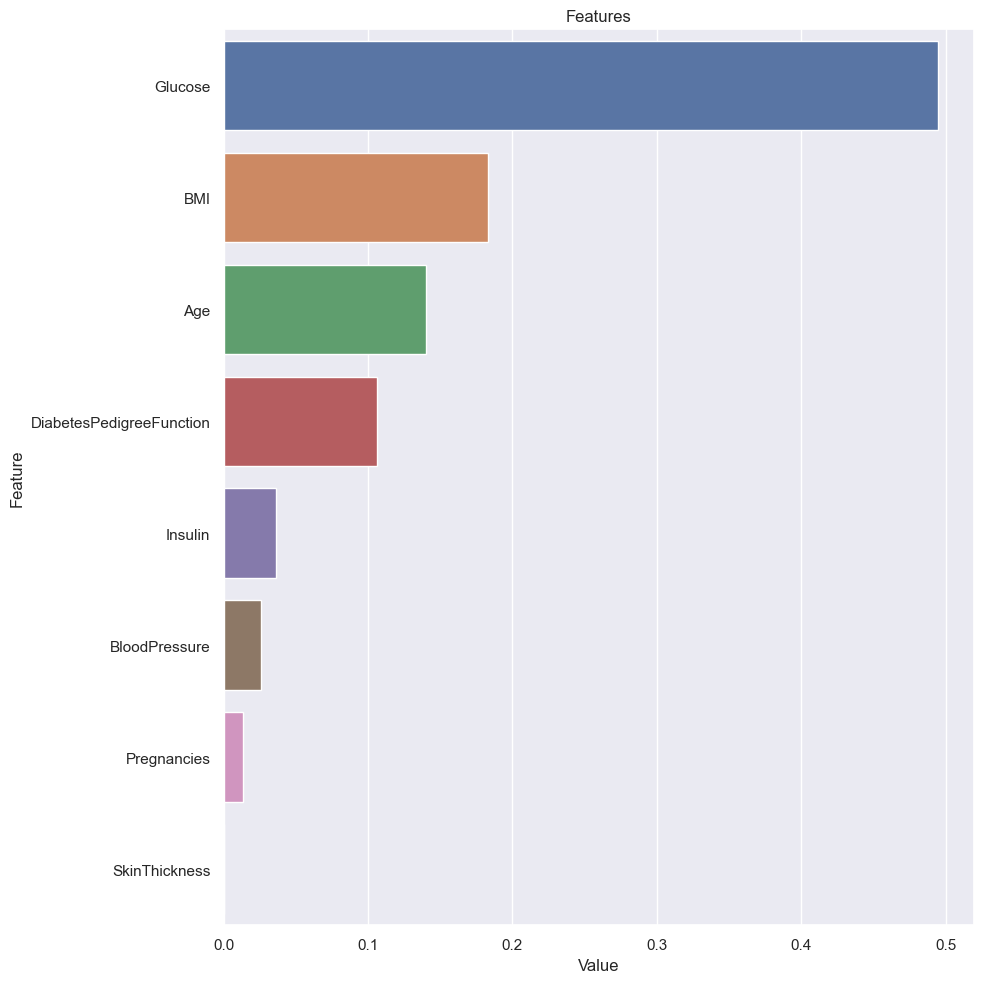

In [44]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(cart_final, X_train)

In [45]:
# Öğrenme Eğrileriyle Model Karmaşıklığı Analiz Etme

In [47]:
train_score, test_score = validation_curve(cart_final, X_train, y_train,
                                          param_name='max_depth',
                                          param_range=range(1,11),
                                          scoring='roc_auc',
                                          cv=10)

In [49]:
mean_train_score = np.mean(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)

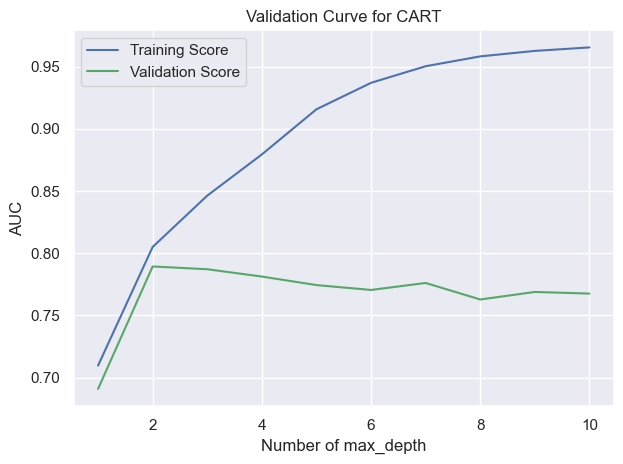

In [50]:
plt.plot(range(1, 11), mean_train_score,
         label="Training Score", color='b')

plt.plot(range(1, 11), mean_test_score,
         label="Validation Score", color='g')

plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [51]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

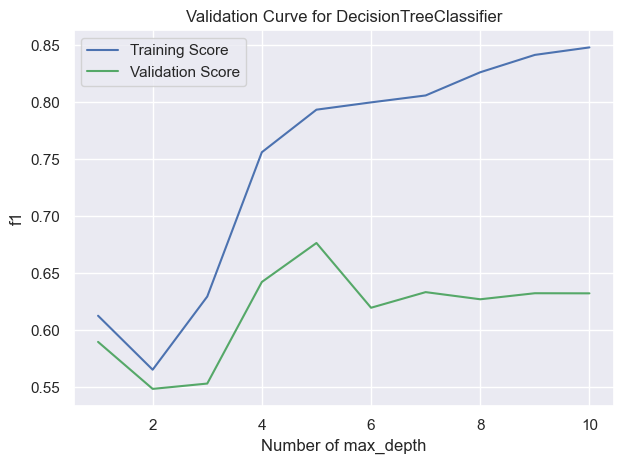

In [53]:
val_curve_params(cart_final, X_train, y_train, "max_depth", range(1, 11), scoring="f1")

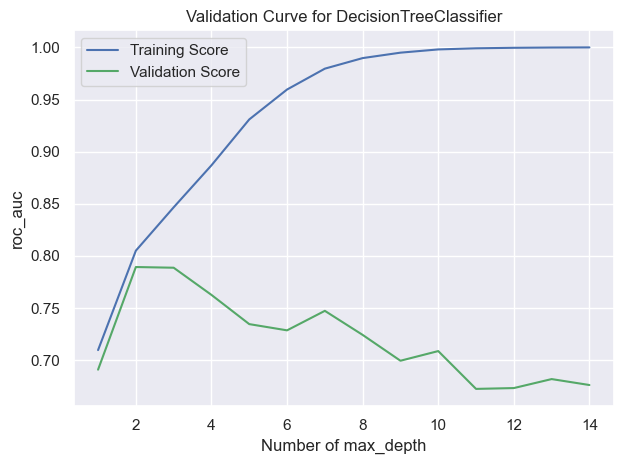

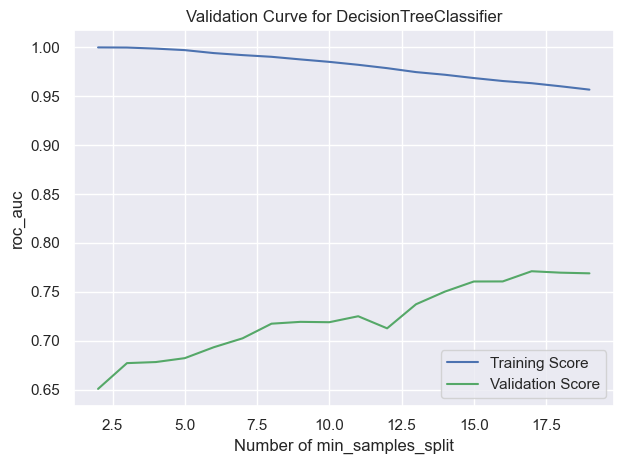

In [55]:
cart_val_params = [["max_depth", range(1, 15)],["min_samples_split", range(2, 20)]]

for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X_train, y_train, cart_val_params[i][0], cart_val_params[i][1])

In [56]:
#Visualizing the Decision Tree

In [61]:
#Eğitilen modeli ağaç olrak görselleştirmek için
def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)


#tree_graph(model=cart_final, col_names=X_train.columns, file_name="cart_final.png")

In [62]:
# Extracting Decision Rules

tree_rules = export_text(cart_final, feature_names=list(X_train.columns))
print(tree_rules)

|--- Glucose <= 0.39
|   |--- Age <= -0.40
|   |   |--- BMI <= 1.70
|   |   |   |--- Pregnancies <= 1.09
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.09
|   |   |   |   |   |--- BloodPressure <= 0.20
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- BloodPressure >  0.20
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.09
|   |   |   |   |   |--- Glucose <= -0.51
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Glucose >  -0.51
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Pregnancies >  1.09
|   |   |   |   |--- class: 1
|   |   |--- BMI >  1.70
|   |   |   |--- class: 1
|   |--- Age >  -0.40
|   |   |--- Glucose <= -0.67
|   |   |   |--- DiabetesPedigreeFunction <= 2.14
|   |   |   |   |--- Glucose <= -2.83
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Glucose >  -2.83
|   |   |   |   |   |--- Insulin <= 0.97
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Insulin >  0.97
|   |  

In [67]:
# Extracting Python Codes of Decision Rules
# Modeli canlıya alırken database dışına çıkmadan işlem yapmayı sağlar
print(skompile(cart_final.predict).to('python/code'))

((((((0 if x[2] <= 0.2013385072350502 else 0) if x[6] <= 
    0.08644696697592735 else 0 if x[1] <= -0.5131020247936249 else 0) if x[
    0] <= 1.085396945476532 else 1) if x[5] <= 1.7016598582267761 else 1) if
    x[7] <= -0.4033912867307663 else ((1 if x[1] <= -2.8290907740592957 else
    0 if x[4] <= 0.9742254167795181 else 1) if x[6] <= 2.141637682914734 else
    1) if x[1] <= -0.6695877611637115 else (1 if x[5] <= -2.816665291786194
     else 0) if x[5] <= -0.7288436889648438 else (0 if x[5] <= 
    -0.2782803624868393 else 0) if x[6] <= -0.662542462348938 else 1 if x[5
    ] <= -0.3417399823665619 else 1) if x[1] <= 0.39451518654823303 else ((
    (1 if x[1] <= 0.48840662837028503 else 1 if x[2] <= -2.125060260295868 else
    0) if x[7] <= 0.6602056324481964 else 0 if x[6] <= -0.662542462348938 else
    1) if x[5] <= 0.48323510587215424 else ((0 if x[6] <= 
    -0.8286489844322205 else 1) if x[4] <= 0.930810958147049 else 0) if x[1
    ] <= 0.9891609251499176 else 0) if x[1] <= 1

In [68]:
#SQL
print(skompile(cart_final.predict).to('sqlalchemy/sqlite'))

SELECT CASE WHEN (x2 <= 0.39451518654823303) THEN CASE WHEN (x8 <= -0.4033912867307663) THEN CASE WHEN (x6 <= 1.7016598582267761) THEN CASE WHEN (x1 <= 1.085396945476532) THEN 0 ELSE 1 END ELSE 1 END ELSE CASE WHEN (x2 <= -0.6695877611637115) THEN CASE WHEN (x7 <= 2.141637682914734) THEN CASE WHEN (x2 <= -2.8290907740592957) THEN 1 ELSE CASE WHEN (x5 <= 0.9742254167795181) THEN 0 ELSE 1 END END ELSE 1 END ELSE CASE WHEN (x6 <= -0.7288436889648438) THEN CASE WHEN (x6 <= -2.816665291786194) THEN 1 ELSE 0 END ELSE CASE WHEN (x7 <= -0.662542462348938) THEN 0 ELSE 1 END END END END ELSE CASE WHEN (x2 <= 1.0517552495002747) THEN CASE WHEN (x6 <= 0.48323510587215424) THEN CASE WHEN (x8 <= 0.6602056324481964) THEN CASE WHEN (x2 <= 0.48840662837028503) THEN 1 ELSE CASE WHEN (x3 <= -2.125060260295868) THEN 1 ELSE 0 END END ELSE CASE WHEN (x7 <= -0.662542462348938) THEN 0 ELSE 1 END END ELSE CASE WHEN (x2 <= 0.9891609251499176) THEN CASE WHEN (x5 <= 0.930810958147049) THEN CASE WHEN (x7 <= -0.828

In [69]:
#Excel

print(skompile(cart_final.predict).to('excel'))

A1=IF((x2<=0.3945151865 ...710 chars skipped... 30781555),1,0),0))))


In [72]:
#Prediction using python codes

def predict_with_rules(x):
    return ((((((0 if x[2] <= 0.2013385072350502 else 0) if x[6] <= 
    0.08644696697592735 else 0 if x[1] <= -0.5131020247936249 else 0) if x[
    0] <= 1.085396945476532 else 1) if x[5] <= 1.7016598582267761 else 1) if
    x[7] <= -0.4033912867307663 else ((1 if x[1] <= -2.8290907740592957 else
    0 if x[4] <= 0.9742254167795181 else 1) if x[6] <= 2.141637682914734 else
    1) if x[1] <= -0.6695877611637115 else (1 if x[5] <= -2.816665291786194
     else 0) if x[5] <= -0.7288436889648438 else (0 if x[5] <= 
    -0.2782803624868393 else 0) if x[6] <= -0.662542462348938 else 1 if x[5
    ] <= -0.3417399823665619 else 1) if x[1] <= 0.39451518654823303 else ((
    (1 if x[1] <= 0.48840662837028503 else 1 if x[2] <= -2.125060260295868 else
    0) if x[7] <= 0.6602056324481964 else 0 if x[6] <= -0.662542462348938 else
    1) if x[5] <= 0.48323510587215424 else ((0 if x[6] <= 
    -0.8286489844322205 else 1) if x[4] <= 0.930810958147049 else 0) if x[1
    ] <= 0.9891609251499176 else 0) if x[1] <= 1.0517552495002747 else (0 if
    x[7] <= -0.6586545407772064 else 1) if x[5] <= -0.2719343900680542 else
    ((1 if x[2] <= 1.2352935075759888 else 1) if x[5] <= 1.7905033230781555
     else 0) if x[6] <= 5.31880259513855 else 0)

In [84]:
#print(X_train.columns)

x = [0.12, 0.20, 0.08, 0.16, 0.19, 0.4, -0.25, 0.3]
print(predict_with_rules(x))

1


In [79]:
#Saving and model loading model

joblib.dump(cart_final, 'cart_final.pkl')

['cart_final.pkl']

In [85]:
cart_model_from_disc = joblib.load("cart_final.pkl")
x = [0.12, 0.20, 0.08, 0.16, 0.19, 0.4, -0.25, 0.3]
predictionss = cart_model_from_disc.predict(pd.DataFrame(x).T)
predictionss

array([1], dtype=int64)